In [3]:
from splitters import k_fold_edge_split
from dataset_loader import load_dataframes
from model import Net
from utils import train_model, device_finder, train_model_on_folds, predict_edges, plot_layers_curve, plot_comparison
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import LocalDegreeProfile
import os
import torch
from torch_geometric.data import Data
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pathlib

warnings.simplefilter(action='ignore', category=FutureWarning)

final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df = load_dataframes()

In [17]:
out_dir = str(pathlib.Path().resolve())
out_path = f'{out_dir}/datasets/dcdb.csv'

if 'dcdb.csv' not in os.listdir(f'{out_dir}/datasets/'):
    src_path = f'{out_dir}/datasets/COMPONENTS.txt'
    f = open(src_path, 'r')

    csv_1 = []
    csv_2 = []

    for line in f.readlines():
        each = line.split(' ')[0].split('\t')
        csv_1.append(each[0])
        csv_2.append(each[1])

    print(len(csv_1))
    print(len(csv_2))

    csv_1 = np.array(csv_1[1:])
    csv_2 = np.array(csv_2[1:])

    csv_1 = np.reshape(csv_1, (len(csv_1), 1))
    csv_2 = np.reshape(csv_2, (len(csv_2), 1))

    drug_df = pd.DataFrame(np.concatenate([csv_1, csv_2], axis=1), columns=['drug', 'name'])
    drug_df

    drug_df.to_csv(out_path, index=False)
else:
    drug_df = pd.read_csv(out_path)

drug_names = dict()

for drug in drug_df.values:
    drug = list(drug)
    drug_names[drug[0]] = drug[1]

all_edges = []

for edge in all_df.values:
    if list(edge) not in all_edges and [edge[1], edge[0]] not in all_edges:
        all_edges.append(list(edge))
        all_edges.append([edge[1], edge[0]])

In [19]:
# loading all edges of undirected graph

x_nv = final_nv_df.iloc[:, :128]
x_nv = np.array(x_nv, dtype=np.float32)

nodes_nv_list = list()
nodes_nv_dict = dict()
reverse_nv_dict = dict()

count = 0
for x in final_nv_df.values[:, 128:129]:
    nodes_nv_dict[str(x.squeeze())] = count
    reverse_nv_dict[count] = str(x.squeeze())
    count+=1
    nodes_nv_list.append(str(x.squeeze()))

edges_nv = list()
for edge in all_edges:
    if edge[0] in nodes_nv_list and edge[1] in nodes_nv_list:
        edges_nv.append([nodes_nv_dict[edge[0]], nodes_nv_dict[edge[1]]])
nodes_nv = list(nodes_nv_dict.values())
nodes_nv = torch.from_numpy(np.array(nodes_nv))
edges_nv = torch.from_numpy(np.array(edges_nv))
x_nv = torch.from_numpy(np.array(x_nv))

data_nv = Data(x=x_nv, edge_index=edges_nv.T)

Epoch: 100, Train Loss: 0.404553, Val Auc: 0.982228, Test Auc: 0.982483


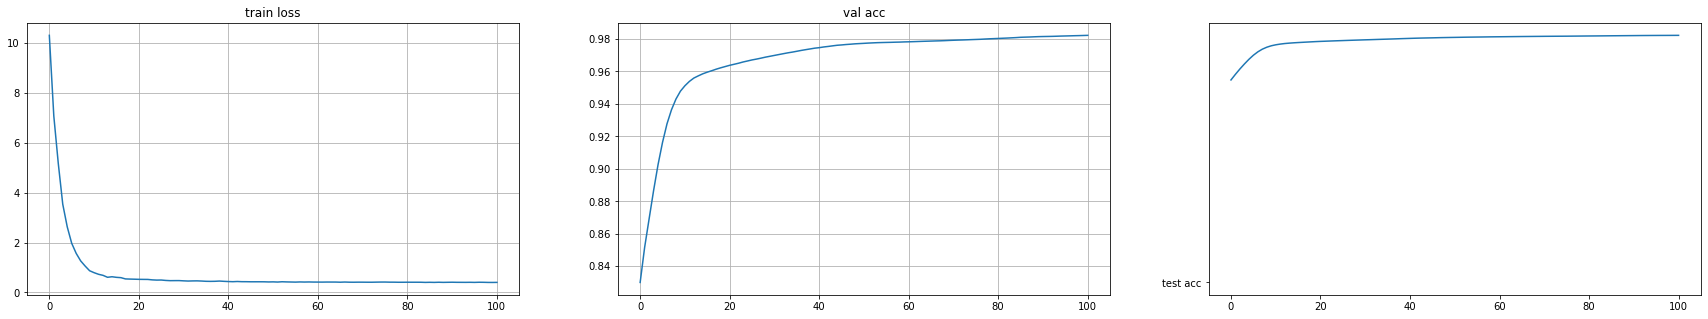

In [21]:
index = 8
device = device_finder()
learning_rate = 0.0001

hid_channels = 128
out_channels = 64

# Scale data before applying PCA
scaling=StandardScaler()
df1 = data_nv.x
# Use fit and transform method
scaling.fit(df1)
Scaled_data=scaling.transform(df1)
# Set the n_components=3
principal=PCA(n_components=32)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
# Check the dimensions of data after PCA

x = torch.from_numpy(x)
x = x.float()
data = Data(x=x, edge_index=edges_nv.T)
folds = k_fold_edge_split(data, only_upper_triangular_portion=False)

device = device_finder()
in_channels = folds[0].num_features

pca_nv_train_loss, pca_nv_val_auc, pca_nv_test_auc, model, pca_nv_val_aupr, pca_nv_test_aupr, pca_nv_val_fscore, pca_nv_test_fscore = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels,
                                                                                hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=learning_rate, verbose=0)

In [22]:
z = model.encode(folds[0].x, data_nv.edge_index, index=index)
final_edge_index, prob_adj = model.decode_all(z)

print('max:', prob_adj.max().detach().numpy())
print('min:', prob_adj.min().detach().numpy())

scaler = MinMaxScaler()
prob_adj = prob_adj.detach().numpy()
prob_adj = scaler.fit_transform(prob_adj)

threshold = 0.95

a = np.array(list((prob_adj > threshold).nonzero())).T

b = []

for e in a:
    b.append(list(e))


found = 0
c_edges = np.array(data_nv.edge_index.T)

all_edges = []

for e in c_edges:
    all_edges.append(list(e))

for edge in b:
    if edge in all_edges:
        found += 1

tensor([[ 6.8173,  3.2964,  3.5055,  ..., -0.8460, -0.8460, -0.8460],
        [ 3.2964,  2.0585,  1.8101,  ..., -0.3428, -0.3428, -0.3428],
        [ 3.5055,  1.8101,  2.9421,  ..., -1.0156, -1.0156, -1.0156],
        ...,
        [-0.8460, -0.3428, -1.0156,  ...,  4.9230,  4.9230,  4.9230],
        [-0.8460, -0.3428, -1.0156,  ...,  4.9230,  4.9230,  4.9230],
        [-0.8460, -0.3428, -1.0156,  ...,  4.9230,  4.9230,  4.9230]],
       grad_fn=<MmBackward0>)
max: 18.035204
min: -5.3720007
found: 637 , new_predicted: 512 , top_over_0.95: 1149 ,  all_true: 3406 , acc: 0.18702290076335878


In [23]:
available_edges = []
for e in edges_nv:
    available_edges.append(list(e.detach().numpy()))

all_0 = []
all_1 = []
all_2 = []

for i in range(prob_adj.shape[0]):
    for j in range(prob_adj.shape[1]):
        if i == j:
            prob_adj[i, j] = 0
        all_0.append(i)
        all_1.append(j)
        all_2.append(prob_adj[i, j])

all_0 = np.array(all_0)
all_1 = np.array(all_1)
all_2 = np.array(all_2)

all_0 = np.reshape(all_0, (len(all_0), 1))
all_1 = np.reshape(all_1, (len(all_1), 1))
all_2 = np.reshape(all_2, (len(all_2), 1))

all = pd.DataFrame(np.concatenate([all_0, all_1], axis=1), columns=['alias1', 'alias2'])
all['score'] = all_2
all = all.sort_values('score', ascending=False)

temp = all[all['score'] > 1].head(40)

import os
out_path = '/home/sina/PycharmProjects/vs_code'
folder_name = 'prediction'

if folder_name not in os.listdir(out_path):
    os.mkdir(f'{out_path}/{folder_name}')


all_3 = []
all_4 = []
all_5 = []

for row in temp[['alias1', 'alias2']].values:
    row = list(row)
    if row in available_edges:
        all_3.append('Original')
    else:
        all_3.append('New')
    all_4.append(drug_names[reverse_nv_dict[row[0]]])
    all_5.append(drug_names[reverse_nv_dict[row[1]]])

temp['type'] = all_3
temp['drug1'] = all_4
temp['drug2'] = all_5

temp.to_csv(f'{out_path}/{folder_name}/best.csv')
temp[temp['type'] == 'New'].head(10)

,alias1,alias2,score,type,drug1,drug2
224769,298,673,1.0,New,Fluoxetine,Riluzole
12216,16,184,1.0,New,Cytarabine,17-DMAG
171371,227,667,1.0,New,Hydrochlorothiazide,Azelnidipine
509642,677,538,1.0,New,Tropisetron,Romiplostim
509281,677,177,1.0,New,Tropisetron,Valproic


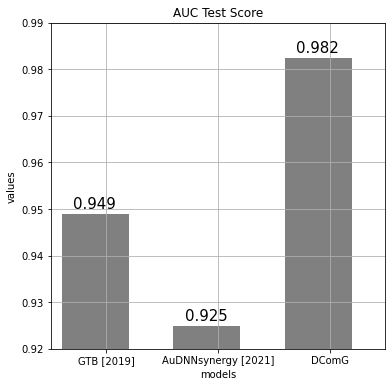

In [26]:
plot_comparison(pca_nv_test_auc[100])